In [60]:
import dataset_eval
from res_unet import resnet18_UNet
from loss_metric import DiceLoss

import os
import time
import json
import torch
import logging
import numpy as np
from torchvision import transforms

import numpy as np
import matplotlib.pyplot as plt
from skimage import io, transform
from PIL import Image, ImageOps
import importlib

from scipy import ndimage as ndi

import skimage
from skimage.segmentation import watershed
from skimage.feature import peak_local_max, canny

# Utils

In [61]:
def return_watershed(image):
    distance = ndi.distance_transform_edt(image)
    coords = peak_local_max(distance, footprint=np.ones((5, 5)), labels=image)
    mask = np.zeros(distance.shape, dtype=bool)
    mask[tuple(coords.T)] = True
    markers, _ = ndi.label(mask)
    labels = watershed(-distance, markers, mask=image)
                     
    return labels

In [62]:
def vis_res(shape, img_tensor, gt_tensor, prob_tensor, pred_tensor, save_path, canon_size=1376):
    H, W = shape
    H = H.numpy()[0]
    W = W.numpy()[0]
    img = img_tensor.cpu().data.numpy()[abs(canon_size - H):,abs(canon_size - W):,:]
    print(img.shape)
    gt = gt_tensor.cpu().data.numpy()[abs(canon_size - H):,abs(canon_size - W):]
    prob = prob_tensor.cpu().data.numpy()[abs(canon_size - H):,abs(canon_size - W):]
    pred = pred_tensor.cpu().data.numpy()[abs(canon_size - H):,abs(canon_size - W):]
    labels = return_watershed(pred)
    gt_labels = return_watershed(gt)
    
    print('Num Labels: ')
    print(len(list(set(labels.flatten()))))
    print('Num GT Labels: ')
    print(len(list(set(gt_labels.flatten()))))

    plt.subplot(1,5,1)
    plt.imshow(img)
    plt.title('Image')
    plt.subplot(1,5,2)
    plt.imshow(gt)
    plt.title('GT')
    plt.subplot(1,5,3)
    plt.imshow(pred)
    plt.title('Pred')
    plt.subplot(1,5,4)
    plt.imshow(labels, cmap=plt.cm.nipy_spectral)
    plt.title('Pred_Labels')
    plt.subplot(1,5,5)
    plt.imshow(gt_labels, cmap=plt.cm.nipy_spectral)
    plt.title('GT_Labels')
    plt.subplots_adjust(wspace=1, hspace=1)
    plt.savefig(save_path, dpi=500)
    plt.close()

# Test

In [63]:
net = resnet18_UNet(pretrained=True, n_class=1, input_size=256)
net.load_state_dict(torch.load("model_49.pt"), strict=True)

<All keys matched successfully>

In [64]:
net.loss = DiceLoss()
net.metric = DiceLoss(get_coefficient=True)
net = net.cuda()

# init dataloader
train_transforms = transforms.Compose([
                        dataset_eval.PadToSquare(),
                        dataset_eval.ToTensor(),
                        dataset_eval.ExtendImageChannel(),
                     ])

# train_transforms = transforms.Compose([
#                         dataset_eval.RandomResizedCrop(size=[256,256]),
#                         dataset_eval.RandomFlip(),
#                         dataset_eval.ToTensor(),
#                         dataset_eval.ExtendImageChannel(),
#                      ])

train_dataset = dataset_eval.MicroscopyDataset("../S-BSST265", "train.txt", transform=train_transforms)
val_dataset = dataset_eval.MicroscopyDataset('../S-BSST265', 'val.txt', transform=train_transforms)

In [65]:
val_dataset.__getitem__(6)[0].shape

torch.Size([3, 1376, 1376])

In [66]:
dataloader = torch.utils.data.DataLoader(val_dataset, batch_size = 1, shuffle=False, num_workers=0, drop_last=False)

In [67]:
acc_list = []
images = []
gt_masks = []
predicted_masks = []
pred_labels = []
pred_labels_gt = []
canon_size = 1376
for iter, data in enumerate(dataloader):
    img, mask, shape = data
    H, W = shape
    H = H.numpy()[0]
    W = W.numpy()[0]
    img = img.float().cuda()
    mask = mask.float().cuda()
    pred = net(img)
    acc = net.metric(pred.detach(), mask.detach())
    acc = acc.cpu().numpy() * 2
    
    print()
    print("Iteration %d" % iter)
    print("Accuracy: ")
    print(acc)
    acc_list.append(acc)

    prob = torch.sigmoid(torch.max(pred[0,:,:,:],0)[0])
    res = prob>0.5
    images.append(img[0,:,:,:].permute(1, 2, 0).cpu().data.numpy()[abs(canon_size - H):,abs(canon_size - W):,:])
    gt_masks.append(mask[0,0,:,:].cpu().data.numpy()[abs(canon_size - H):,abs(canon_size - W):])
    predicted_masks.append(res.cpu().data.numpy()[abs(canon_size - H):,abs(canon_size - W):])
    pred_labels.append(return_watershed(res.cpu().data.numpy()[abs(canon_size - H):,abs(canon_size - W):]))
    pred_labels_gt.append(return_watershed(mask[0,0,:,:].cpu().data.numpy()[abs(canon_size - H):,abs(canon_size - W):]))
    vis_res(shape, img[0,:,:,:].permute(1, 2, 0), mask[0,0,:,:], prob, res, save_path='./test_%d.png' % iter)


Iteration 0
Accuracy: 
0.7001460194587708
(914, 1225, 3)
Num Labels: 
690
Num GT Labels: 
544

Iteration 1
Accuracy: 
0.48829832673072815
(430, 550, 3)
Num Labels: 
276
Num GT Labels: 
195

Iteration 2
Accuracy: 
0.826598584651947
(1024, 1280, 3)
Num Labels: 
371
Num GT Labels: 
93

Iteration 3
Accuracy: 
0.827887773513794
(1024, 1280, 3)
Num Labels: 
352
Num GT Labels: 
87

Iteration 4
Accuracy: 
0.9679539799690247
(1024, 1280, 3)
Num Labels: 
455
Num GT Labels: 
48

Iteration 5
Accuracy: 
0.9611995816230774
(1024, 1280, 3)
Num Labels: 
281
Num GT Labels: 
66

Iteration 6
Accuracy: 
0.7865908145904541
(1024, 1360, 3)
Num Labels: 
172
Num GT Labels: 
117

Iteration 7
Accuracy: 
0.9322893619537354
(1024, 1280, 3)
Num Labels: 
256
Num GT Labels: 
125

Iteration 8
Accuracy: 
0.946703314781189
(1024, 1024, 3)
Num Labels: 
308
Num GT Labels: 
256


In [68]:
np.array(acc_list).mean()

0.8264075285858579

In [82]:
image_num = 8

In [83]:
gt_mask = gt_masks[image_num].astype(np.int8)
pred_mask = predicted_masks[image_num].astype(np.int8)

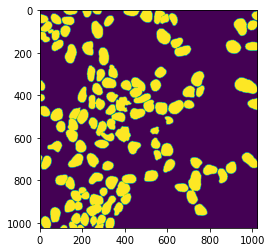

In [84]:
plt.imshow(gt_masks[image_num])

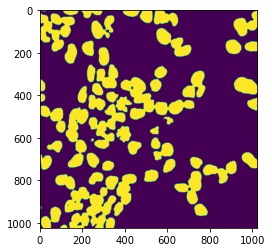

In [85]:
plt.imshow(predicted_masks[image_num])

In [86]:
edge_width = 10

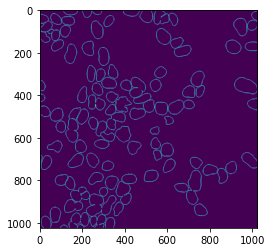

In [87]:
edge_gt = canny(gt_masks[image_num],sigma=0)
plt.imshow(edge_gt)

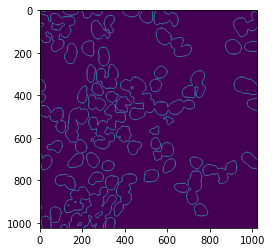

In [88]:
edge_pred = canny(predicted_masks[image_num],sigma=0)
plt.imshow(edge_pred)

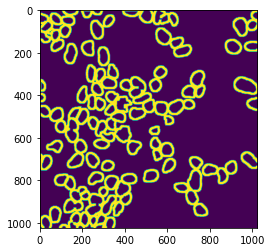

In [89]:
kernel = np.ones((edge_width, edge_width),np.uint8)
edge_gt_dilated = skimage.morphology.binary_dilation(edge_gt, kernel)
plt.imshow(edge_gt_dilated)

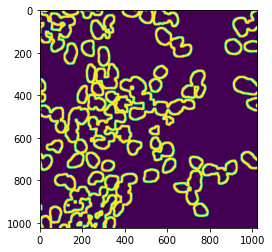

In [90]:
edge_pred_dilated = skimage.morphology.binary_dilation(edge_pred, kernel)
plt.imshow(edge_pred_dilated)

In [91]:
edge_gt_dilated = edge_gt_dilated.astype(np.int)
edge_pred_dilated = edge_pred_dilated.astype(np.int)

In [92]:
dice = np.sum(edge_pred_dilated * edge_gt_dilated)*2.0 / (np.sum(edge_pred_dilated) + np.sum(edge_gt_dilated))
print(dice)

0.8607906733813506


In [93]:
from stardist.matching import matching_dataset
gt_metrics = matching_dataset(edge_gt_dilated, edge_pred_dilated, thresh=0, show_progress=False)

In [94]:
gt_metrics.mean_true_score

0.7582447225688657